# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 1. Read Datas

In [2]:
# using the SQLite Table to read data.
sql = sqlite3.connect("database.sqlite")
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points
data = pd.read_sql_query("""select * from Reviews WHERE Score != 3""", sql)
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.

def partition(x):
    if x<3:
        return 0
    else:
        return 1 
#changing reviews with score less than 3 to be positive and vice-versa
part = data["Score"].map(partition)
data["Score"] = part

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


<b>Duplicate Datas</b>

In [4]:
new_data = pd.read_sql_query("""SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*) from Reviews
GROUP BY UserId
HAVING COUNT(*)>1""",sql)

In [5]:
new_data.head()

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
new_data[new_data["COUNT(*)"] == new_data["COUNT(*)"].max()]

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
57359,A3OXHLG6DIBRW8,B002O3VHXU,"C. F. Hill ""CFH""",1282176000,5,"Green Mountain ""Nantucket Blend"" K-Cups make a...",448


In [7]:
new_data["COUNT(*)"].value_counts()[0:10]

2     32658
3     13828
4     10589
5      5417
6      4137
7      2691
8      1953
9      1805
10     1231
11      991
Name: COUNT(*), dtype: int64

In [8]:
new_data.shape

(80668, 7)

In [9]:
new_data["COUNT(*)"].sum()

393063

#  Exploratory Data Analysis

## 2. Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", sql)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [11]:
data_sorted = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data_final = data_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(f"Shape of dataset: {data_final.shape}")
print(f"About {round((1-data_final.shape[0]/data_sorted.shape[0])*100,2)}%\
 of the original datas has been deleted due to duplication")

Shape of dataset: (364173, 10)
About 30.74% of the original datas has been deleted due to duplication


<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", sql)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
data_final = data_final[data_final["HelpfulnessDenominator"]>=data_final["HelpfulnessNumerator"]]

In [14]:
data_final.shape

(364171, 10)

In [15]:
data_final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [16]:
percent = data_final["Score"].value_counts().min()/len(data_final["Score"])
print(f"Negative reviews is just a {round(percent*100,2)}% of total dataset")

Negative reviews is just a 15.68% of total dataset


So obviously, the dataset is highly unbalanced and we cannot use accuracy score as the evaluation metrics.

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
print(data_final["Text"].values[0])
print("="*100)
print(data_final["Text"].values[1000])
print("="*100)
print(data_final["Text"].values[1500])
print("="*100)
print(data_final["Text"].values[1700])
print("="*100)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [18]:
from bs4 import BeautifulSoup
#Remove HTML tags and URL from the reviews.
def html_tag(phrase):
    http_remove = re.sub(r"http\S+", "",phrase)
    html_remove = BeautifulSoup(http_remove, 'lxml').get_text()
    return html_remove

In [19]:
phrase = data_final["Text"].values[0]
print(f"Before tag Remover: \n {phrase}")
print("="*90)
phrase = html_tag(data_final["Text"].values[0])
print(f"After tag removed: \n {phrase}")

Before tag Remover: 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
After tag removed: 
 this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
import re
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
phrase = data_final["Text"].values[1500]
print(f"Before: {phrase}")
print("="*90)
r1500 = html_tag(data_final["Text"].values[1500])
r1500 = decontracted(r1500)
print(f"After: {r1500}")

Before: Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today's Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70's it was poisonous until they figured out a way to fix that. I still like it but it could be better.
After: Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say othe

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
data_final.shape

(364171, 10)

In [24]:
data_final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [25]:
from tqdm import tqdm

In [26]:
processed_review = []
for i in tqdm(data_final["Text"].values):
    sentance = html_tag(i)
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance)
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = " ".join(i.lower() for i in sentance.split() if i.lower() not in stopwords)
    processed_review.append(sentance)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:56<00:00, 3113.91it/s]


In [27]:
data_final["Clean text"] = processed_review

In [28]:
len(processed_review)

364171

# 4. Featurization
## 4.1 Bag of Words

In [34]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [30]:
x = data_final["Clean text"][0:50000]
y = data_final["Score"][0:50000]

In [35]:
xx, x_cv, yy, y_cv = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=1)
print(f"X CV Shape: {x_cv.shape}")
print(f"Y CV Shape: {y_cv.shape}")
print(f"X train shape: {x_train.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"Y test shape: {y_test.shape}")

X CV Shape: (10000,)
Y CV Shape: (10000,)
X train shape: (32000,)
Y train shape: (32000,)
X test shape: (8000,)
Y test shape: (8000,)


In [37]:
bow = CountVectorizer()
bow.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [38]:
train_bow = bow.transform(x_train)
cv_bow = bow.transform(x_cv)
test_bow = bow.transform(x_test)

In [41]:
neighbors = np.arange(5,50,5)
cv_auc = []
for i in tqdm(neighbors):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_bow,y_train)
    x_cv_pred_prob = neigh.predict_proba(cv_bow)
    x_cv_auc = roc_auc_score(y_cv, x_cv_pred_prob[:,1])
    cv_auc.append(x_cv_auc)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:56<00:00, 13.01s/it]


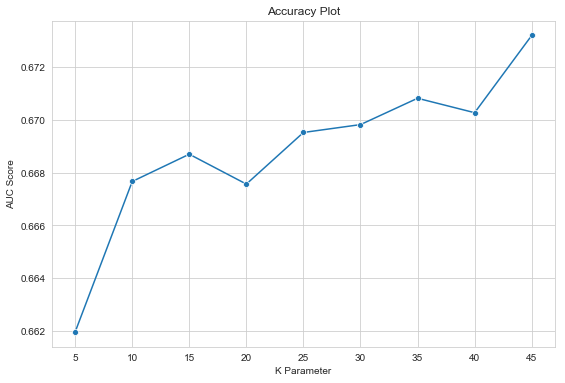

In [46]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(neighbors, cv_auc, marker="o")
plt.xlabel("K Parameter")
plt.ylabel("AUC Score")
plt.title("Accuracy Plot")
plt.show()

In [47]:
knn = KNeighborsClassifier(n_neighbors=6)

In [48]:
knn.fit(train_bow,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='uniform')

In [51]:
train_fpr, train_tpr, train_thr = roc_curve(y_train, knn.predict_proba(train_bow)[:,1])

In [52]:
test_fpr, test_tpr, test_thr = roc_curve(y_test, knn.predict_proba(test_bow)[:,1])

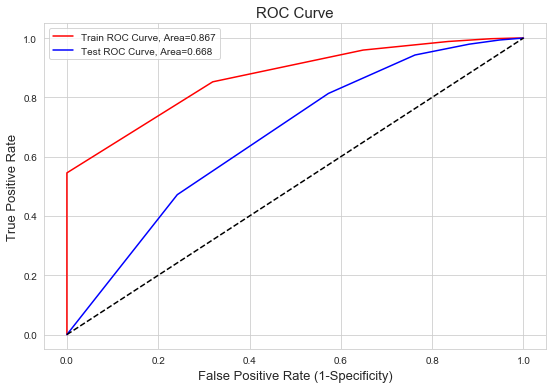

In [57]:
plt.figure(figsize=(9,6))
plt.plot(train_fpr,train_tpr,"r",label=f"Train ROC Curve, Area={round(auc(train_fpr,train_tpr),3)}")
plt.plot(test_fpr,test_tpr,"b",label=f"Test ROC Curve, Area={round(auc(test_fpr,test_tpr),3)}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve",fontsize=15)
plt.legend(loc="best")
plt.xlabel("False Positive Rate (1-Specificity)",fontsize=13)
plt.ylabel("True Positive Rate",fontsize=13)
plt.show()

In [58]:
cm = confusion_matrix(y_train, knn.predict(train_bow), labels=[1,0])

          Predicted-1  Predicted-0
Actual-1        26096         1101
Actual-0         3116         1687


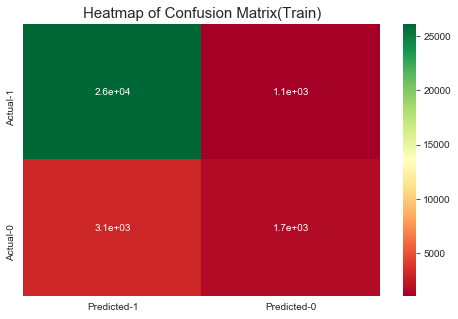

In [60]:
cm_df = pd.DataFrame(data=cm,columns=["Predicted-1","Predicted-0"],index=["Actual-1","Actual-0"])
print(f"{cm_df}")
print("="*100)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df,cmap="RdYlGn",annot=True)
plt.title("Heatmap of Confusion Matrix(Train)",fontsize=15)
plt.show()

In [61]:
cm = confusion_matrix(y_test, knn.predict(test_bow), labels=[1,0])

          Predicted-1  Predicted-0
Actual-1         6424          389
Actual-0          905          282


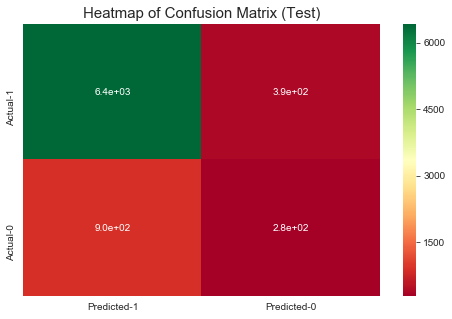

In [62]:
cm_df = pd.DataFrame(data=cm,columns=["Predicted-1","Predicted-0"],index=["Actual-1","Actual-0"])
print(f"{cm_df}")
print("="*100)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df,cmap="RdYlGn",annot=True)
plt.title("Heatmap of Confusion Matrix (Test)",fontsize=15)
plt.show()

In [63]:
#KNN Kd-tree

In [65]:
x = data_final["Clean text"][0:50000]
y = data_final["Score"][0:50000]
xx, x_cv, yy, y_cv = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_test, y_train, y_test = train_test_split(xx,yy, test_size=0.2, random_state=1)
print(f"X CV Shape: {x_cv.shape}")
print(f"Y CV Shape: {y_cv.shape}")
print(f"X train shape: {x_train.shape}")
print(f"Y train shape: {y_train.shape}")
print(f"X test shape: {x_test.shape}")
print(f"Y test shape: {y_test.shape}")

X CV Shape: (10000,)
Y CV Shape: (10000,)
X train shape: (32000,)
Y train shape: (32000,)
X test shape: (8000,)
Y test shape: (8000,)


In [66]:
bow = CountVectorizer(min_df=10, max_features=500)
bow.fit(x_train)
train_bow = bow.transform(x_train)
cv_bow = bow.transform(x_cv)
test_bow = bow.transform(x_test)

In [67]:
train_bow = train_bow.todense()
cv_bow = cv_bow.todense()
test_bow = test_bow.todense()

In [ ]:
neighbors = np.arange(5,50,5)
cv_auc = []
for i in tqdm(neighbors):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(train_bow,y_train)
    x_cv_pred_prob = neigh.predict_proba(cv_bow)
    x_cv_auc = roc_auc_score(y_cv, x_cv_pred_prob[:,1])
    cv_auc.append(x_cv_auc)

 11%|█████████▏                                                                         | 1/9 [06:09<49:17, 369.67s/it]

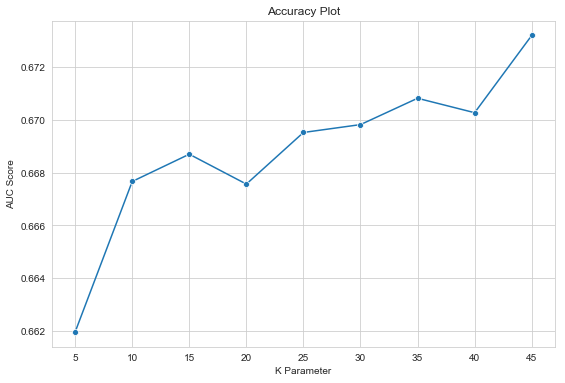

In [64]:
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.lineplot(neighbors, cv_auc, marker="o")
plt.xlabel("K Parameter",fontsize=13)
plt.ylabel("AUC Score",fontsize=13)
plt.title("Accuracy Plot", fontsize=15)
plt.show()

## 4.2 Bi-Grams and n-Grams.

In [30]:
n_gram = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_ngram = n_gram.fit_transform(processed_review)
print(f"Shape of Sparse matrix {final_ngram.get_shape()}")
print(f"Number of unique words: {final_ngram.get_shape()[1]}")
print(f"Some sample words: {n_gram.get_feature_names()[0:10]}")

Shape of Sparse matrix (4986, 3144)
Number of unique words: 3144
Some sample words: ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']


## 4.3 TF-IDF

In [31]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tfidf = tfidf.fit_transform(processed_review)
print(f"Shape of Sparse matrix {final_tfidf.get_shape()}")
print(f"Number of unique words: {final_tfidf.get_shape()[1]}")
print(f"Some sample words: {tfidf.get_feature_names()[0:10]}")

Shape of Sparse matrix (4986, 3144)
Number of unique words: 3144
Some sample words: ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']


## 4.4 Word2Vec

In [32]:
list_of_sentance=[]
for sentance in processed_review:
    list_of_sentance.append(sentance.split())

In [33]:
len(list_of_sentance)

4986

In [34]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9941299557685852), ('overall', 0.9934208989143372), ('medicinal', 0.9929832220077515), ('especially', 0.9927810430526733), ('snack', 0.9924875497817993), ('looking', 0.9923187494277954), ('regular', 0.9921613335609436), ('calorie', 0.9921408891677856), ('alot', 0.9920685291290283), ('anything', 0.9920647144317627)]
[('awful', 0.9994140863418579), ('wow', 0.9993860125541687), ('turned', 0.9993847608566284), ('opinion', 0.9993643760681152), ('liked', 0.9993429183959961), ('experience', 0.999325692653656), ('hands', 0.9993187785148621), ('gourmet', 0.9992948174476624), ('reviewers', 0.9992819428443909), ('become', 0.999257504940033)]


In [35]:
print(f"Number of words which occurs a least of 5 times: {len(list(w2v_model.wv.vocab))}")
print(f"Sample words which occurs a least of 5 times: {list(w2v_model.wv.vocab)[0:10]}")
w2v_words = list(w2v_model.wv.vocab)

Number of words which occurs a least of 5 times: 3817
Sample words which occurs a least of 5 times: ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca']


### 4.4.1 Converting text into vectors using wAvg W2V

In [36]:
avg_vector = []
for sent in tqdm(list_of_sentance):
    word_count = 0
    word_vector = np.zeros(50)
    for words in sent:
        if words in w2v_words:
            word_count +=1 
            each_word_vect = w2v_model.wv[words]
            word_vector += each_word_vect
    if word_count != 0: 
        word_vector /= word_count
    avg_vector.append(word_vector)

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1453.13it/s]


### 4.4.2 Converting text into vectors using TFIDF Weighted W2V

In [37]:
tf_idf = TfidfVectorizer()
tf_idf.fit(processed_review)
dictionary = dict(zip(tf_idf.get_feature_names(), list(tf_idf.idf_)))
tf_idf_features = tf_idf.get_feature_names()

In [38]:
model = TfidfVectorizer()
model.fit(processed_review)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))


# TF-IDF weighted Word2Vec

tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and ce
ll_val = tfidf
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:23<00:00, 210.30it/s]


# 5. Applying TSNE


<ol> 
    <li> You need to plot 4 tsne plots with each of these feature set
        <ol>
            <li>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ol>
    </li>
    <li> <font color='blue'>Note 1: The TSNE accepts only dense matrices</font></li>
    <li> <font color='blue'>Note 2: Consider only 5k to 6k data points </font></li>
</ol>

## 5.1 TNSE on BOW vectors

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(final_bow.todense())
tsne_df = pd.DataFrame({"Dim1":tsne_result[:,0], "Dim2":tsne_result[:,1]})
tsne_df["Score"] = data_final["Score"]
print(tsne_df.head())
print("="*60)
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.scatterplot(tsne_df["Dim1"],tsne_df["Dim2"],hue=tsne_df["Score"])
plt.title("TSNE of Bag of Words")
plt.show()

## 5.2 TSNE of N-Gram or bi-gram

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(final_ngram.todense())
tsne_df = pd.DataFrame({"Dim1":tsne_result[:,0], "Dim2":tsne_result[:,1]})
tsne_df["Score"] = data_final["Score"]
print(tsne_df.head())
print("="*60)
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.scatterplot(tsne_df["Dim1"],tsne_df["Dim2"],hue=tsne_df["Score"])
plt.title("TSNE of Bag of Words")
plt.show()

## 5.3 TSNE of TFIDF

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(final_tfidf.todense())
tsne_df = pd.DataFrame({"Dim1":tsne_result[:,0], "Dim2":tsne_result[:,1]})
tsne_df["Score"] = data_final["Score"]
print(tsne_df.head())
print("="*60)
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.scatterplot(tsne_df["Dim1"],tsne_df["Dim2"],hue=tsne_df["Score"])
plt.title("TSNE of Bag of Words")
plt.show()

## 5.4 TSNE on Average W2V

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(avg_vector)
tsne_df = pd.DataFrame({"Dim1":tsne_result[:,0], "Dim2":tsne_result[:,1]})
tsne_df["Score"] = data_final["Score"]
print(tsne_df.head())
print("="*60)
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.scatterplot(tsne_df["Dim1"],tsne_df["Dim2"],hue=tsne_df["Score"])
plt.title("TSNE of Bag of Words")
plt.show()

## 5.5 TSNE on TFIDF weighted W2V

In [ ]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=5000)
tsne_result = tsne.fit_transform(tfidf_sent_vectors)
tsne_df = pd.DataFrame({"Dim1":tsne_result[:,0], "Dim2":tsne_result[:,1]})
tsne_df["Score"] = data_final["Score"]
print(tsne_df.head())
print("="*60)
plt.figure(figsize=(9,6))
sns.set_style(style="whitegrid")
sns.scatterplot(tsne_df["Dim1"],tsne_df["Dim2"],hue=tsne_df["Score"])
plt.title("TSNE of Bag of Words")
plt.show()